In [1]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import torch

from dLDS_continuous import dLDS_continuous, fit_dLDS
from utils import solve_trajectory, get_dynamics_on_grid

/Users/yenho/miniconda3/envs/pt/lib/python3.8/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/yenho/miniconda3/envs/pt/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
#  plots dictionary elements

def plot_dictionary(As, bs, M, T_pred, title, rslds=True, s=0.2):
    
    f,axs = plt.subplots(n_disc_states,1, figsize=(3,2*n_disc_states), sharex=True, dpi=150)
    
    for k, (a, b, ax)  in enumerate(zip(As, bs, axs)):
        if rslds:
            X, Y = np.meshgrid(*[np.arange(-2, 2+0.01, 0.5) for i in range(2)])
            xy = np.c_[X.flatten(), Y.flatten()]
            U,V  = (xy @ a.T + b - xy).T
            
            pred = [x0.flatten()]
            for i in T_pred:
                x0_ = pred[-1][:,None]
                x1_hat = (a @ x0_ + b[:,None]).flatten()
                pred.append(x1_hat)
            pred = np.c_[pred]
            
        else: 
            X, dXdt = get_dynamics_on_grid(a, [-2, -2], [2,2], step=0.5)
            X, Y = X
            U, V = dXdt
            pred = solve_trajectory(a.numpy(), x0, T_pred)
            
            
        ax.plot(*pred.T, linewidth=2)
        ax.set_aspect(1)
        ax.quiver(X, Y, U, V, units='x', scale=s)
        ax.set_xlim(-2,2)
        ax.set_ylim(-2,2)
        ax.set_yticks(np.arange(-2,3))
        ax.set_ylabel(rf'$G_{k}$')
        
        [i.set_linewidth(2) for i in ax.spines.values()]
        
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)   
    plt.show()
        

In [3]:
# generate ground truth coefficients on true dynamics 
# switching dynamics

A = np.array([[-0.01, 1.0],
              [-1.0, -0.01]])


cs = np.array([1, 2, 3, 4]) # speed of each switch
switch_ts = np.array([5,5,5, 5]) # length of each segment
switch_ts_ = np.concatenate([[0], switch_ts])

x0 = np.array([[-1,1]])

DATA = [x0]
c_true = []
T = [[0]]
for k,(c, t) in enumerate(zip(cs, switch_ts)):
    samples_per_t = 100
    
    x0_ = DATA[-1][-1]
    t_ = np.linspace(0, t, samples_per_t*t+1)
    x_ = solve_trajectory(A*c, x0_, t_)
    DATA.append(x_[1:])
    
    n_samples = samples_per_t*switch_ts_[k+1]+1
    
    start_t = np.cumsum(switch_ts_)[k]
    end_t = np.cumsum(switch_ts_)[k+1]
    T.append(np.linspace(start_t, end_t, n_samples)[1:])
    c_true.append(np.ones(n_samples)*c)

T = np.concatenate(T)
c_true = np.concatenate(c_true)
X = data =  np.concatenate(DATA)

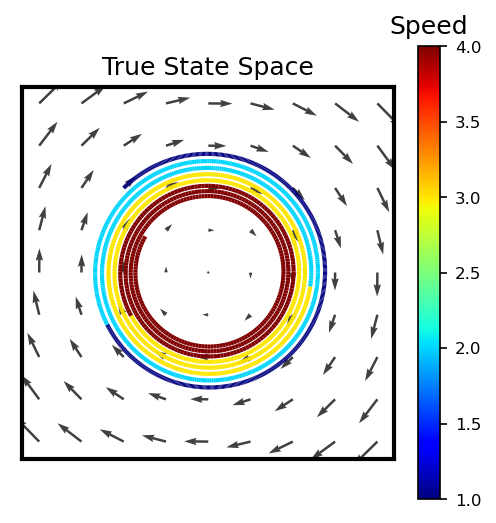

In [4]:
#  plot true state space

points = X[:,None,:]
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, dpi=150, figsize=(4,4))
axs.set_aspect(1)

norm = plt.Normalize(c_true.min(), c_true.max())
lc = LineCollection(segments, cmap='jet', norm=norm)
lc.set_array(c_true)
lc.set_linewidth(2)
line = axs.add_collection(lc)
clb = fig.colorbar(line, ax=axs)
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Speed')

# plot vector field
X, dXdt = get_dynamics_on_grid(A, [-2,-2], [2, 2], step=0.5)
axs.quiver(*X, *dXdt,alpha=0.75)
axs.set_xticks([])
axs.set_yticks([])
[i.set_linewidth(2) for i in axs.spines.values()]
plt.title('True State Space')

# plt.savefig('fig2_speed.true_state_space.svg')
plt.show()




## Fit RSLDS

In [5]:
import ssm
from ssm.util import random_rotation, find_permutation


n_disc_states = 4
latent_dim = 2      # number of latent dimensions
emissions_dim = 2     # number of observed dimensions

print("Fitting SLDS with Laplace-EM")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_id", transitions='recurrent_only',)

# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=100, alpha=0.0, )

q_lem_x = q_lem.mean_continuous_states[0] # Get the posterior mean of the continuous states
q_lem_z = slds.most_likely_states(q_lem_x, data) # Find the permutation that matches the true and inferred states
q_lem_y = slds.smooth(q_lem_x, data) # Smooth the data under the variational posterior




Fitting SLDS with Laplace-EM


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

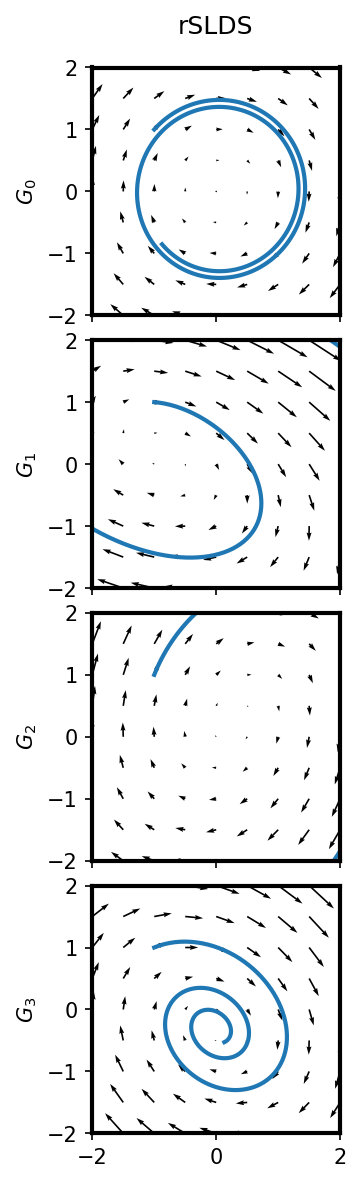

In [6]:
T_pred = np.linspace(0,5, samples_per_t*5+1) 
As = slds.dynamics.As
bs = slds.dynamics.bs
M = 4
x0 = np.array([[-1,  1]])
title = "rSLDS"

plot_dictionary(As, bs, M, T_pred, title)



## Fit dLDS

In [7]:
device = 'cpu'


M = 4 # n dictionary elements
N = 2 # dim of latent space

dLDS = dLDS_continuous(M, N)


# create point pairs
z0 = torch.tensor(data[:-1]).float()
z1 = torch.tensor(data[1:]).float()

In [8]:
fit_dLDS(dLDS, z0, z1)

Epoch	Loss		Time
0	0.202217	1.529770
1	0.201363	1.480819
2	0.194056	1.537194
3	0.157785	1.429710
4	0.141838	1.313945
5	0.157461	1.249151
6	0.159409	1.168196
7	0.139432	1.128306
8	0.120148	1.099820
9	0.113393	1.127576
10	0.115004	0.999790
11	0.117408	1.007562
12	0.117610	1.030761
13	0.117439	1.067969
14	0.117868	1.080004
15	0.118900	1.125649
16	0.119656	1.028067
17	0.119612	1.053344
18	0.119169	1.050592
19	0.118510	0.993270
20	0.117841	1.020474
21	0.117577	1.004065
22	0.117338	1.081671
23	0.117253	0.993608
24	0.117236	1.085351
25	0.117330	1.156731
26	0.117427	1.079123
27	0.117598	1.217598
28	0.117679	1.100385
29	0.117787	1.178430
30	0.117758	1.057785
31	0.117755	1.035396
32	0.117705	1.040789
33	0.117662	1.062709
34	0.117567	1.106142
35	0.117663	0.954437
36	0.117633	1.010724
37	0.117666	0.998515
38	0.117555	1.043264
39	0.117644	1.070393
40	0.117583	1.064563
41	0.117631	1.079808
42	0.117601	1.061842
43	0.117646	0.981403
44	0.117660	1.055176
45	0.117655	1.084875
46	0.117668	1.066583
47	0.1

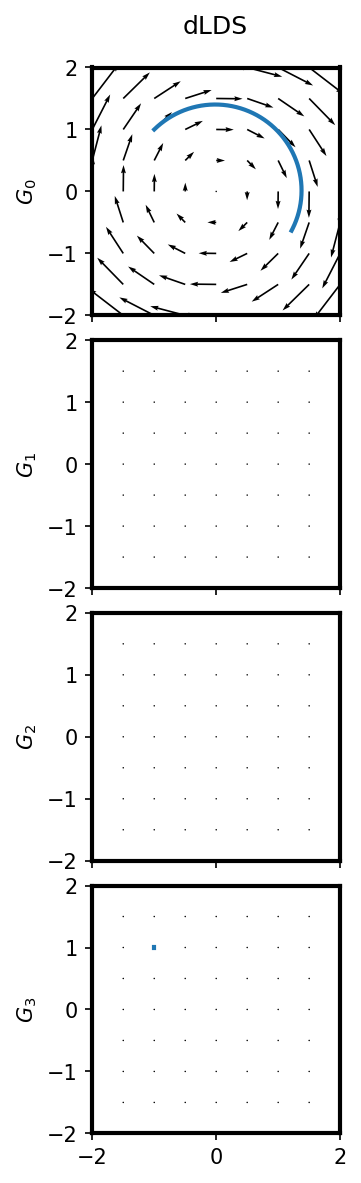

In [9]:

            
T_pred = np.linspace(0,5, samples_per_t*5+1) 
As = dLDS.get_G()
bs = [np.zeros(2)]*M
M = 4
x0 = np.array([[-1,  1]])
title = "dLDS"

plot_dictionary(As, bs, M, T_pred, title, rslds=False, s=2)


    
    
    
    
    
    
    

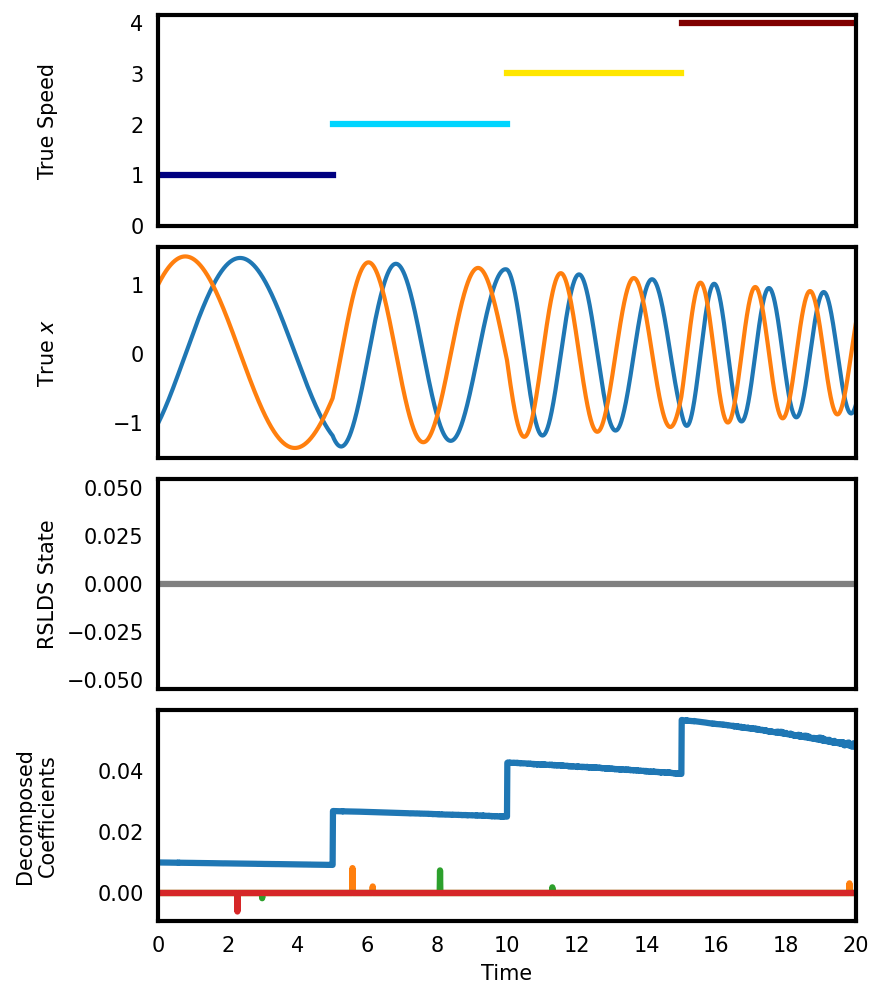

In [10]:
c_pred = dLDS.c

plt.rcParams['text.usetex'] = False

#  show trajectory
f, axs = plt.subplots(4, 1, figsize=(6,8), sharex=True, dpi=150)


# axs[0].plot(T[1:], c_true, 'gray', linewidth=3)


for k,(c, t) in enumerate(zip(cs, switch_ts)):
    samples_per_t = 100    

    #     plotting
    start_t = np.cumsum(switch_ts_)[k]
    end_t = np.cumsum(switch_ts_)[k+1]
    T_ = np.linspace(start_t, end_t, samples_per_t*switch_ts_[k+1]+1)[1:]
    
    
    axs[0].plot(T_, np.ones(len(T_))*c, c=plt.cm.jet(norm(c)), linewidth=3)
axs[0].set_ylabel('True Speed')
axs[0].set_yticks(np.arange(0,np.ceil(c_true.max()+1)))

axs[0]


data = np.concatenate(DATA)
for x in data.T:
    axs[1].plot(T, x, linewidth=2)

# axs[1].set_xticks(np.arange())
axs[1].set_xlim(0, T.max())
axs[1].set_ylabel(r'True $x$')
axs[3].set_xlabel('Time')
for ax in axs:
    ax.tick_params(bottom=False,left=False)
    [i.set_linewidth(2) for i in ax.spines.values()]


axs[1].set_xticks(np.arange(0,21,2))
axs[2].set_ylabel('RSLDS State')
axs[2].plot(T[:], q_lem_z, 'gray', linewidth=3)


axs[3].set_ylabel('Decomposed\nCoefficients')
for c_ in c_pred.T:
    axs[3].plot(T[1:], c_, linewidth=3)

plt.subplots_adjust(hspace=0.1)
f.align_ylabels(axs)
# plt.savefig('fig2_speed.true_and_pred_x.svg')
plt.show()



In [11]:
# MSE

from dLDS_continuous import infer_coefficients

zeta = 1e-1
C = infer_coefficients(z0, z1, dLDS.get_G(), zeta, )
dLDS.set_coefficients(C[1])

z1_hat = dLDS(z0[:,:,None]).squeeze()
mse_dlds = ((z1_hat - z1)**2).sum(1)



In [13]:
y1 = z1_hat.detach().numpy().flatten()
y2 = z1.detach().numpy().flatten()


In [15]:

def corr(x0, x1):
    mu_0 = x0.mean()
    mu_1 = x1.mean()

    cov = np.sum((x0 - mu_0)*(x1 - mu_1))
    sd0 = np.sqrt(np.sum((x0 - mu_0)**2))
    sd1 = np.sqrt(np.sum((x1 - mu_1)**2))

    r = cov/(sd0*sd1)
    return r

r = corr(y1, y2)
r2 = r**2

r2


0.9999589924248085

In [16]:

z0_ = z0.numpy()
z1_ = z1.numpy()

z1_hat = []
for k, i in enumerate(q_lem_z[1:]):
    a, b = slds.dynamics.As[i], slds.dynamics.bs[i]
    z1_hat.append((a @ z0_[k][:,None] + b[:,None]).flatten())

z1_hat = np.c_[z1_hat]
mse_rslds = ((z1_hat - z1_)**2).sum(1)

In [18]:
y1 = z1_hat.flatten()
y2 = z1.detach().numpy().flatten()

r = corr(y1, y2)
r2 = r**2

r2


0.9998869318401699

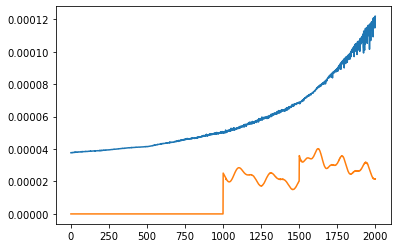

In [101]:
plt.plot(mse_dlds.detach().numpy())
plt.plot(mse_rslds)

In [75]:
z1_hat, z1_

(array([[-0.98985119,  1.00984874],
        [-0.97960535,  1.01959462],
        [-0.96926376,  1.02923667],
        ...,
        [-0.77870088,  0.36139852],
        [-0.76334493,  0.39208484],
        [-0.7467722 ,  0.42213244]]),
 array([[-0.9898511 ,  1.0098488 ],
        [-0.97960544,  1.0195948 ],
        [-0.96926373,  1.0292368 ],
        ...,
        [-0.7767237 ,  0.36557907],
        [-0.7611773 ,  0.39619035],
        [-0.7444227 ,  0.42613548]], dtype=float32))

In [19]:
r

0.9999434643219435

In [ ]:
pred = [x0.flatten()]
            for i in T_pred:
                x0_ = pred[-1][:,None]
                x1_hat = (a @ x0_ + b[:,None]).flatten()
                pred.append(x1_hat)
            pred = np.c_[pred]